In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

C:\Users\Fadri\anaconda3\envs\testo_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}.")

Current device: cuda.


In [3]:
class CityscapesDataset(Dataset):

    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.files = sorted(os.listdir(self.data_dir))
        self.image_paths = []
        self.label_paths = []


    def __len__(self):

        return len(self.files)


    def __getitem__(self, idx):

        image_path = os.path.join(self.data_dir, self.files[idx])
        image = Image.open(image_path).convert("RGB")

        width, height = image.size
        real_image = image.crop((0, 0, width // 2, height))                     # due to data being concatenated horizontally
        segmented_image = image.crop((width //2, 0, width, height))             # due to data being concatenated horizontally

        if self.transform:
            real_image = self.transform(real_image)
            segmented_image = self.transform(segmented_image)

        return segmented_image, real_image

In [4]:
SIZE = 256
batch_size = 1
root_dir = "dataset/"
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

data_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CityscapesDataset(train_dir, transform=data_transforms)
val_dataset = CityscapesDataset(val_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True)

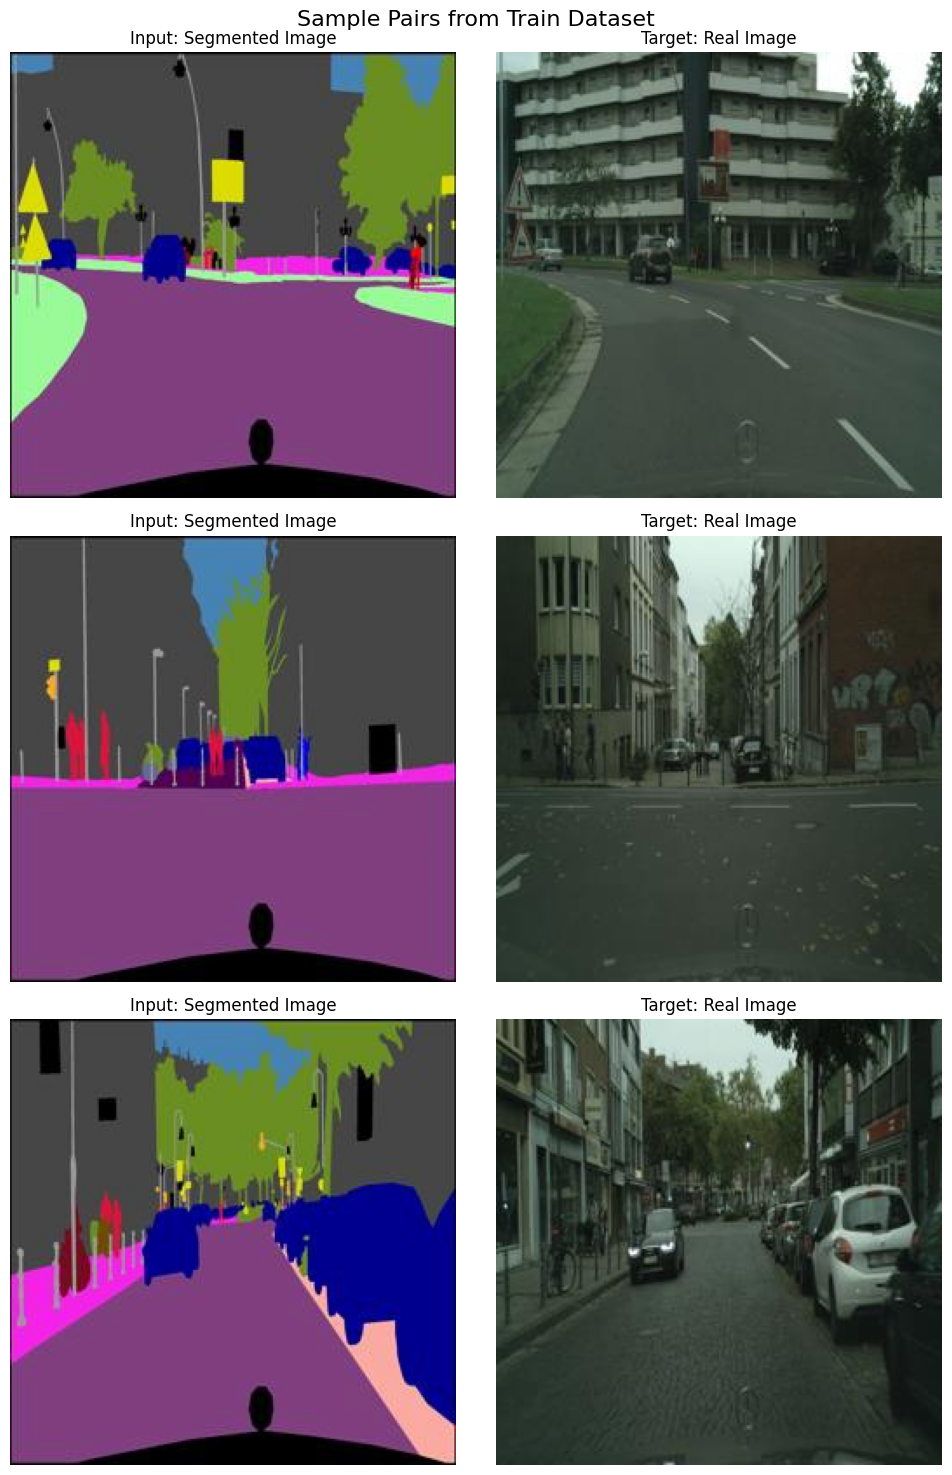

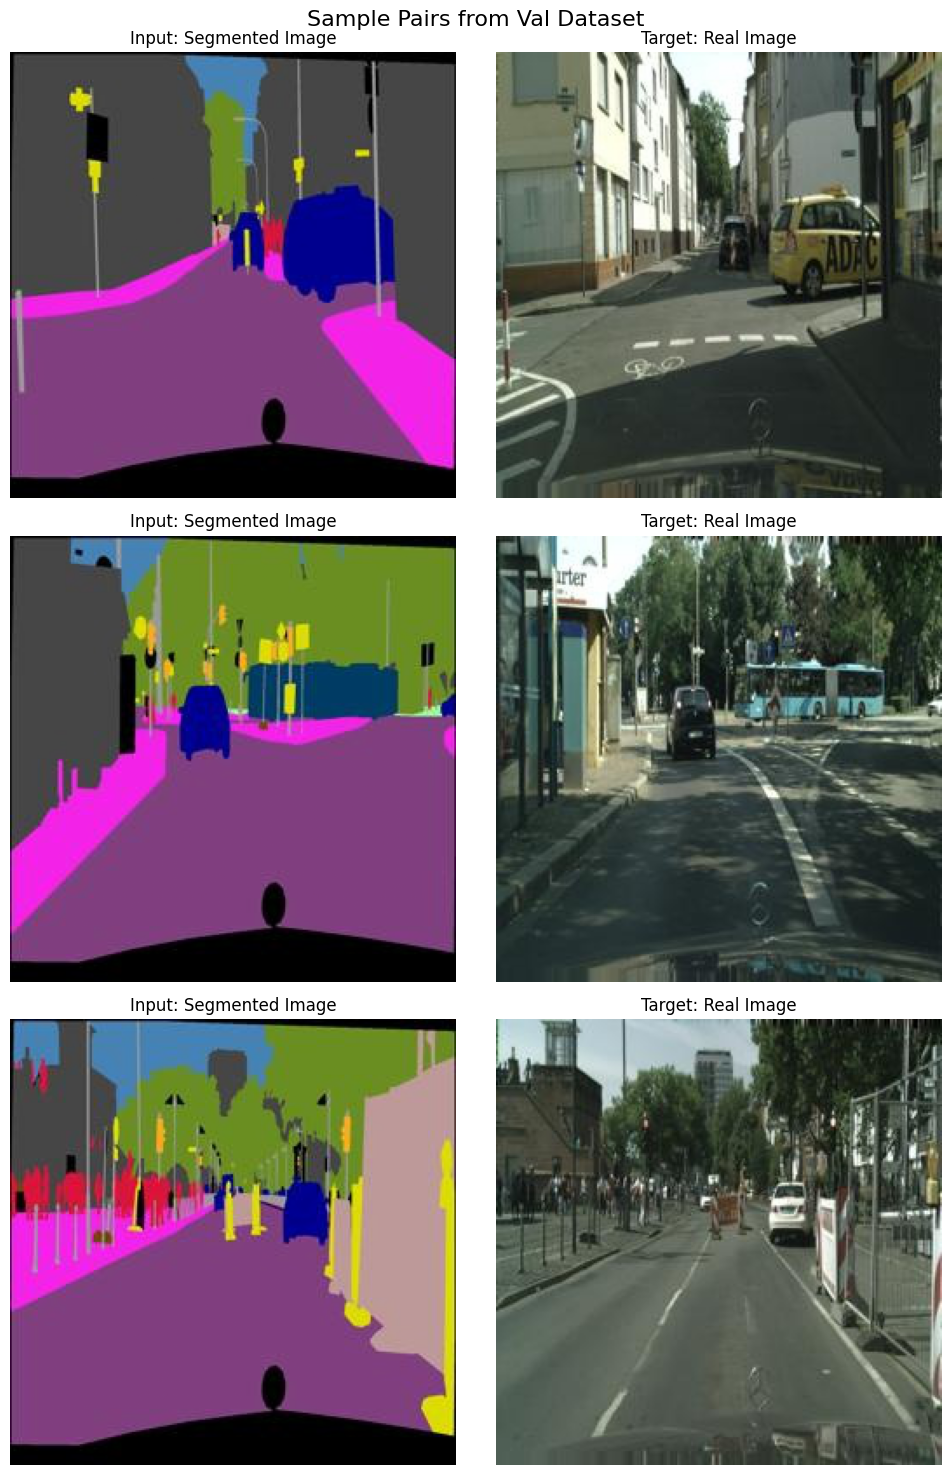

In [5]:
def display_sample_pairs(dataset, num_pairs=10, title="Sample Pairs"):

    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))
    fig.suptitle(title, fontsize=16)

    for i in range(num_pairs):
        segmented_image, real_image = dataset[i]
        segmented_image = segmented_image.permute(1, 2, 0) * 0.5 + 0.5          # denormalize for visualization
        real_image = real_image.permute(1, 2, 0) * 0.5 + 0.5                    # denormalize for visualization

        axes[i, 0].imshow(segmented_image)
        axes[i, 0].set_title("Input: Segmented Image")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(real_image)
        axes[i, 1].set_title("Target: Real Image")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_pairs(train_dataset, num_pairs=3, title="Sample Pairs from Train Dataset")
display_sample_pairs(val_dataset, num_pairs=3, title="Sample Pairs from Val Dataset")

In [6]:
class Discriminator(nn.Module):

    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        # helper function to construct layers quickly
        def conv_block(in_c, out_c, stride):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=4, stride=stride, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        # due to concatenated input of segmented+real, in_channels=in_channels*2
        self.model = nn.Sequential(
            nn.Conv2d(in_channels*2, 64, kernel_size=4, stride=2, padding=1),     # C64, no BatchNorm
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(64, 128, stride=2),                                        # C128
            conv_block(128, 256, stride=2),                                       # C256
            conv_block(256, 512, stride=1),                                       # C512 (stride 1 for 70x70 patches)

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),                # Final layer
            nn.Sigmoid()
        )


    def forward(self, x, y):

        concatenated = torch.cat([x, y], dim=1)
        verdict = self.model(concatenated)

        return verdict

In [7]:
class DownSample(nn.Module):

    def __init__(self, in_channels, out_channels, apply_batchnorm=True):
        super(DownSample, self).__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=not(apply_batchnorm))]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        self.down = nn.Sequential(*layers)


    def forward(self, x):

        return self.down(x)


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(UpSample, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        self.up = nn.Sequential(*layers)


    def forward(self, x, skip):

        x = self.up(x)
        x = torch.cat([x, skip], dim=1)                                         # skip connection
        return x


class Generator(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        # Encoder (DownSampling)
        self.down1 = DownSample(in_channels, 64, apply_batchnorm=False)         # C64
        self.down2 = DownSample(64, 128)                                        # C128
        self.down3 = DownSample(128, 256)                                       # C256
        self.down4 = DownSample(256, 512)                                       # C512
        self.down5 = DownSample(512, 512)                                       # C512
        self.down6 = DownSample(512, 512)                                       # C512
        self.down7 = DownSample(512, 512)                                       # C512
        self.down8 = DownSample(512, 512)                                       # C512

        # Decoder (Upsampling)
        self.up1 = UpSample(512, 512, apply_dropout=True)                       # CD512
        self.up2 = UpSample(1024, 512, apply_dropout=True)                      # CD1024
        self.up3 = UpSample(1024, 512, apply_dropout=True)                      # CD1024
        self.up4 = UpSample(1024, 512)                                          # C1024
        self.up5 = UpSample(1024, 256)                                          # C1024
        self.up6 = UpSample(512, 128)                                           # C512
        self.up7 = UpSample(256, 64)                                            # C256

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )


    def forward(self, x):

        # Encoder forward
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Decoder forward + skip connections (U-Net)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [8]:
class Pix2Pix(nn.Module):

    def __init__(self, generator, discriminator):
        super(Pix2Pix, self).__init__()

        self.generator = generator
        self.discriminator = discriminator
        self.criterion_gan = nn.BCEWithLogitsLoss()
        self.criterion_l1 = nn.L1Loss()


    def generator_loss(self, fake_output, fake_target, real_target, lambda_l1=100):

        adversarial_loss = self.criterion_gan(fake_output, torch.ones_like(fake_output, device=fake_output.device))
        l1_loss = self.criterion_l1(fake_target, real_target)

        total_loss = adversarial_loss + lambda_l1 * l1_loss
        return total_loss


    def discriminator_loss(self, real_output, fake_output):

        real_loss = self.criterion_gan(real_output, torch.ones_like(real_output, device=real_output.device))
        fake_loss = self.criterion_gan(fake_output, torch.zeros_like(fake_output, device=fake_output.device))

        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
pix2pix = Pix2Pix(generator, discriminator).to(device)

print(pix2pix)

Pix2Pix(
  (generator): Generator(
    (down1): DownSample(
      (down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (down2): DownSample(
      (down): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (down3): DownSample(
      (down): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (down4): DownSample(
      (down): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

In [10]:
def train_pix2pix(pix2pix_model, train_loader, val_loader, epochs, lambda_l1, display_interval):

    start_time = time.time()
    train_g_losses, train_d_losses = [], []
    val_g_losses, val_d_losses = [], []

    for epoch in range(epochs):

        # training
        pix2pix_model.train()
        train_g_loss, train_d_loss = 0.0, 0.0

        for idx, (segmented_images, real_images) in enumerate(tqdm(train_loader, desc=f"Training {epoch+1}/{epochs}")):
            segmented_images = segmented_images.to(device)
            real_images = real_images.to(device)

            # train model discriminator
            d_optimizer.zero_grad()
            fake_images = pix2pix_model.generator(segmented_images)
            real_output = pix2pix_model.discriminator(segmented_images, real_images)
            fake_output = pix2pix_model.discriminator(segmented_images, fake_images)
            d_loss = pix2pix_model.discriminator_loss(real_output, fake_output)
            d_loss.backward()
            d_optimizer.step()

            # train model generator
            g_optimizer.zero_grad()
            fake_images = pix2pix_model.generator(segmented_images)
            fake_output = pix2pix_model.discriminator(segmented_images, fake_images)
            g_loss = pix2pix_model.generator_loss(fake_output, fake_images, real_images, lambda_l1)
            g_loss.backward()
            g_optimizer.step()

            train_d_loss += d_loss.item()
            train_g_loss += g_loss.item()

        # average train loss per epoch
        train_d_losses.append(train_d_loss / len(train_loader))
        train_g_losses.append(train_g_loss / len(train_loader))

        # validating
        pix2pix_model.eval()
        val_g_loss, val_d_loss = 0.0, 0.0

        with torch.no_grad():
            for idx, (segmented_images, real_images) in enumerate(tqdm(val_loader, desc=f"Validating {epoch+1}/{epochs}")):
                segmented_images = segmented_images.to(device)
                real_images = real_images.to(device)

                fake_images = pix2pix_model.generator(segmented_images)
                real_output = pix2pix_model.discriminator(segmented_images, real_images)
                fake_output = pix2pix_model.discriminator(segmented_images, fake_images)

                d_loss = pix2pix_model.discriminator_loss(real_output, fake_output)
                g_loss = pix2pix_model.generator_loss(fake_output, fake_images, real_images, lambda_l1)

                val_d_loss += d_loss.item()
                val_g_loss += g_loss.item()

        # average val loss per epoch
        val_d_losses.append(val_d_loss / len(val_loader))
        val_g_losses.append(val_g_loss / len(val_loader))

        print(f"Epoch {epoch + 1}/{epochs} | G Train Loss: {train_g_losses[-1]:.4f} | D Train Loss: {train_d_losses[-1]:.4f} | G Val Loss: {val_g_losses[-1]:.4f} | D Val Loss: {val_d_losses[-1]:.4f}")

        # display sample results after each interval
        if (epoch + 1) % display_interval == 0 or (epoch + 1) == epochs:
            display_generated_samples(pix2pix_model, train_loader, num_samples=3)

    print(f"Training Completed in {time.time() - start_time:.2f} seconds.")
    return train_g_losses, train_d_losses, val_g_losses, val_d_losses


def display_generated_samples(model, loader, num_samples=10, title="Generated Samples"):

    model.eval()
    with torch.no_grad():
        segmented_images, real_images = next(iter(loader))
        segmented_images = segmented_images[:num_samples].to(device)
        real_images = real_images[:num_samples].to(device)

        fake_images = model.generator(segmented_images)

        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        fig.suptitle(title, fontsize=16)

        for i in range(num_samples):
            axes[i, 0].imshow((segmented_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)         # denormalizing
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis('off')
            axes[i, 1].imshow((real_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)              # denormalizing
            axes[i, 1].set_title("Target Image")
            axes[i, 1].axis('off')
            axes[i, 2].imshow((fake_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)              # denormalizing
            axes[i, 2].set_title("Generated Image")
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()

In [11]:
num_epochs = 50
learning_rate = 2e-4
lambda_l1 = 100
display_interval = 10

g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

train_g_losses, train_d_losses, val_g_losses, val_d_losses = train_pix2pix(pix2pix, train_loader, val_loader, num_epochs, lambda_l1, display_interval)

Training 1/50:   0%|                                                                          | 0/2975 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 14052) exited unexpectedly